In [175]:
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
  print('CUDA is not available. Training on CPU ...')
else:
  print('CUDA is available! Training on GPU ...')

CUDA is available! Training on GPU ...


Загрузка данных

In [176]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2


In [177]:
# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
transforms.ToTensor(),
transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# choose the training and test datasets
train_data = datasets.CIFAR10('data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [178]:
# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]


In [179]:
# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)



In [180]:
# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
num_workers=num_workers)

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

Визуализация данных(одного батча)

In [181]:
import matplotlib.pyplot as plt
%matplotlib inline
# helper function to un-normalize and display an image
def imshow(img):
  img = img / 2 + 0.5 # unnormalize
  plt.imshow(np.transpose(img, (1, 2, 0))) # convert from Tensor image

In [182]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display

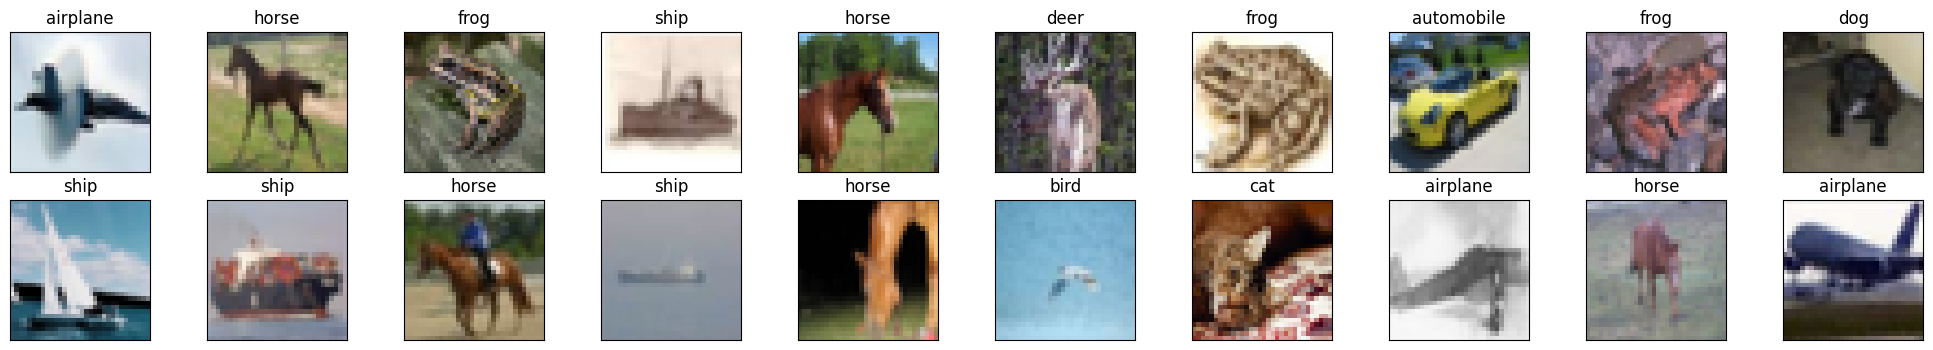

In [183]:
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
  ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
  imshow(images[idx])
  ax.set_title(classes[labels[idx]])

Архитектура сети

In [184]:
import torch.nn as nn
import torch.nn.functional as F
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(3, 8, 3, padding=1)

        self.bn1 = nn.BatchNorm2d(8)

        self.conv2 = nn.Conv2d(8, 32, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)

        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)


        self.pool = nn.MaxPool2d(2,2)
        #128*8*8 -> 400
        self.fc1 = nn.Linear(128*16*16, 400)
        # 400 -> 10
        self.fc2 = nn.Linear(400, 10)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)


    def forward(self, x):

        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = x.view(-1, 128*8*8)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [185]:
# create a complete CNN
model = Net()
print(model)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)


Net(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(8, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32768, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


Net(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(8, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32768, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

Функция потерь и оптимизатор

In [186]:
import torch.optim as optim
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()
# specify optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

Обучение сети

In [187]:
def train_model(model, optimizer, train_loader, valid_loader, criterion, device, num_epochs=100):
    valid_loss_min = np.Inf # track change in validation loss
    for epoch in range(1, num_epochs+1):
      # keep track of training and validation loss
      train_loss = 0.0
      valid_loss = 0.0
      ###################
      # train the model #
      ###################
      model.train()
      for data, target in train_loader:
          # move tensors to device
          data, target = data.to(device), target.to(device)
          # clear the gradients of all optimized variables
          optimizer.zero_grad()
          # forward pass: compute predicted outputs by passing inputs to the model
          output = model(data)
          # calculate the batch loss
          loss = criterion(output, target)
          # backward pass: compute gradient of the loss with respect to model parameters
          loss.backward()
          # perform a single optimization step (parameter update)
          optimizer.step()
          # update training loss
          train_loss += loss.item()*data.size(0)
      ######################
      # validate the model #
      ######################
      model.eval()
      for data, target in valid_loader:
          # move tensors to GPU if CUDA is available
          if train_on_gpu:
              data, target = data.cuda(), target.cuda()
          # forward pass: compute predicted outputs by passing inputs to the model
          output = model(data)
          # calculate the batch loss
          loss = criterion(output, target)
          # update average validation loss
          valid_loss += loss.item()*data.size(0)
      # calculate average losses
      train_loss = train_loss/len(train_loader.dataset)
      valid_loss = valid_loss/len(valid_loader.dataset)
      # print training/validation statistics
      print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
          epoch, train_loss, valid_loss))
      # save model if validation loss has decreased
      if valid_loss <= valid_loss_min:
          print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
          valid_loss_min,
          valid_loss))
          torch.save(model.state_dict(), 'best_model_cifar.pth')
          valid_loss_min = valid_loss


In [172]:
train_model(model, optimizer, train_loader, valid_loader, criterion, device, num_epochs=10)

Epoch: 1 	Training Loss: 1.192399 	Validation Loss: 0.217633
Validation loss decreased (inf --> 0.217633).  Saving model ...
Epoch: 2 	Training Loss: 0.858765 	Validation Loss: 0.180135
Validation loss decreased (0.217633 --> 0.180135).  Saving model ...
Epoch: 3 	Training Loss: 0.740204 	Validation Loss: 0.167647
Validation loss decreased (0.180135 --> 0.167647).  Saving model ...
Epoch: 4 	Training Loss: 0.662287 	Validation Loss: 0.162355
Validation loss decreased (0.167647 --> 0.162355).  Saving model ...
Epoch: 5 	Training Loss: 0.600568 	Validation Loss: 0.143916
Validation loss decreased (0.162355 --> 0.143916).  Saving model ...
Epoch: 6 	Training Loss: 0.546971 	Validation Loss: 0.137399
Validation loss decreased (0.143916 --> 0.137399).  Saving model ...
Epoch: 7 	Training Loss: 0.493867 	Validation Loss: 0.133229
Validation loss decreased (0.137399 --> 0.133229).  Saving model ...
Epoch: 8 	Training Loss: 0.457102 	Validation Loss: 0.133401
Epoch: 9 	Training Loss: 0.418984 

Тестирование

In [173]:
#загрузка
model.load_state_dict(torch.load('best_model_cifar.pth'))

# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
model.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    data, target = data.to(device), target.to(device)
    #if train_on_gpu:
    #    data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))
for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))# obtain one batch of test images

<ipython-input-173-ffe06df67d14>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model_cifar.pth'))


Test Loss: 0.652027

Test Accuracy of airplane: 84% (845/1000)
Test Accuracy of automobile: 88% (882/1000)
Test Accuracy of  bird: 73% (738/1000)
Test Accuracy of   cat: 57% (575/1000)
Test Accuracy of  deer: 63% (632/1000)
Test Accuracy of   dog: 71% (718/1000)
Test Accuracy of  frog: 82% (828/1000)
Test Accuracy of horse: 83% (839/1000)
Test Accuracy of  ship: 89% (899/1000)
Test Accuracy of truck: 89% (890/1000)

Test Accuracy (Overall): 78% (7846/10000)


Визуализация некоторых результатов

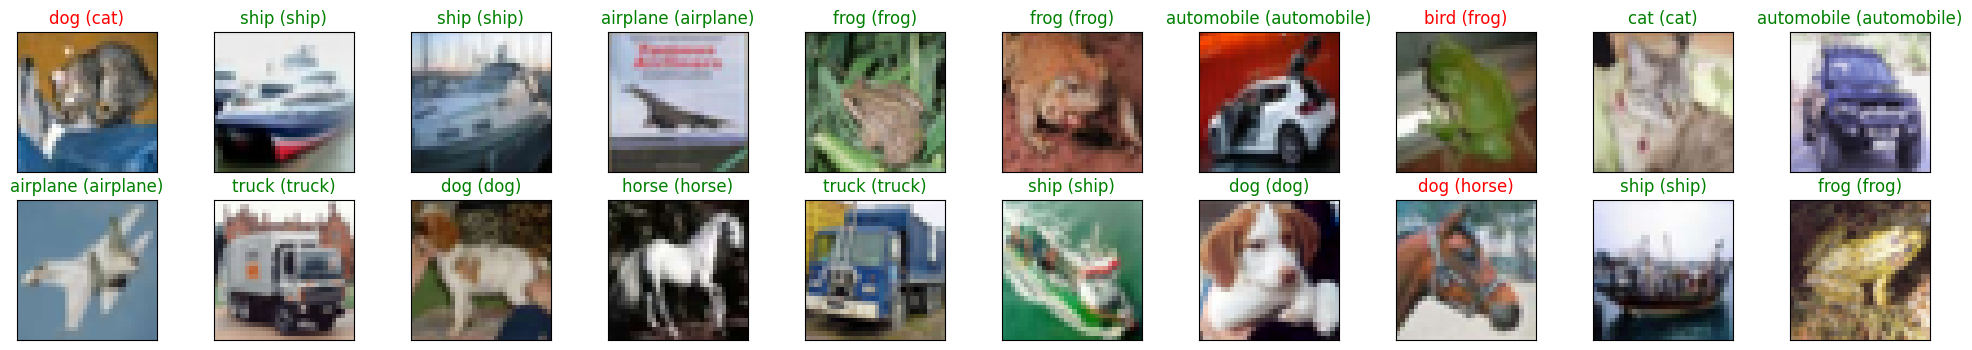

In [174]:
dataiter = iter(test_loader)
images, labels = next(dataiter)
images.numpy()
# move model inputs to cuda, if GPU available
images = images.to(device)
# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())
# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    imshow(images[idx].cpu())
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))
